In [2]:
# Cell 1: Imports
import pandas as pd
import os
from pathlib import Path
import tempfile
from deepfake_eval.loaders import ASVspoof2021DFLoader
from deepfake_eval.path_utils import data_path
from deepfake_eval.utils import convert_asvspoof_scores_txt_to_pkl

In [3]:
# Cell 2: Configuration, Conversion, Load Data, Calculate EER, and Clean Up
MODEL_NAME = "SLSforASVspoof"  # Changed to SLS model name
DATASET_NAME = "ASVspoof2021 DF"

# Paths - updated for SLS
TXT_SCORE_FILE_PATH = data_path("scores", "sls", "sls_asvspoof2021DF_scores.txt")  # Updated path
AUDIO_DIR_PREFIX = "ASVspoof2021_DF_eval/flac"

# Create a temporary file for the PKL
with tempfile.NamedTemporaryFile(suffix='.pkl', delete=False) as temp_file:
    TEMP_PKL_PATH = temp_file.name

try:
    # Convert TXT to temporary PKL
    convert_asvspoof_scores_txt_to_pkl(
        txt_score_file_path=str(TXT_SCORE_FILE_PATH),
        output_pkl_path=TEMP_PKL_PATH,
        audio_dir_prefix=AUDIO_DIR_PREFIX
    )
    
    # Load data using the temporary PKL
    loader = ASVspoof2021DFLoader.from_pkl_dict(
        score_pkl=TEMP_PKL_PATH,
        model_name=MODEL_NAME
    )
    df_scores = loader.to_dataframe()
    
    # Calculate EER and metrics
    print(f"Calculating EER for {MODEL_NAME} on {DATASET_NAME}...\n")
    
    eer, eer_threshold = loader.eer()
    CALIBRATED_THRESHOLD = eer_threshold
    
    num_bonafide = (df_scores['df_class'] == 'bonafide').sum()
    num_spoof = (df_scores['df_class'] == 'spoof').sum()
    
    print(f"--- Calibration Results ---")
    print(f"Model: {MODEL_NAME}")
    print(f"Dataset: {DATASET_NAME}")
    print(f"EER: {eer:.4f} (i.e., {eer*100:.2f}%)")
    print(f"Threshold for EER: {CALIBRATED_THRESHOLD:.4f}")
    print(f"Number of bona fide samples: {num_bonafide}")
    print(f"Number of spoof samples: {num_spoof}")
    print(f"---------------------------")
    print(f"\nCalibrated threshold for {MODEL_NAME} on {DATASET_NAME} is: {CALIBRATED_THRESHOLD:.4f}")

except Exception as e:
    print(f"Error: {e}")
    
finally:
    # Clean up the temporary file
    if os.path.exists(TEMP_PKL_PATH):
        os.remove(TEMP_PKL_PATH)

Reading TXT score file: /home/rvirgilli/Projects/voice-deepfake-detection-br/data/scores/sls/sls_asvspoof2021DF_scores.txt
Found 611829 scores. Saving to PKL: /tmp/tmplz6dav6o.pkl
Successfully converted and saved to /tmp/tmplz6dav6o.pkl


Building records 2021 DF: 100%|██████████| 533928/533928 [00:04<00:00, 116463.69it/s]


Calculating EER for SLSforASVspoof on ASVspoof2021 DF...

--- Calibration Results ---
Model: SLSforASVspoof
Dataset: ASVspoof2021 DF
EER: 0.0192 (i.e., 1.92%)
Threshold for EER: -11.5222
Number of bona fide samples: 14869
Number of spoof samples: 519059
---------------------------

Calibrated threshold for SLSforASVspoof on ASVspoof2021 DF is: -11.5222


/tmp/ipykernel_189337/1593414672.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Classe")


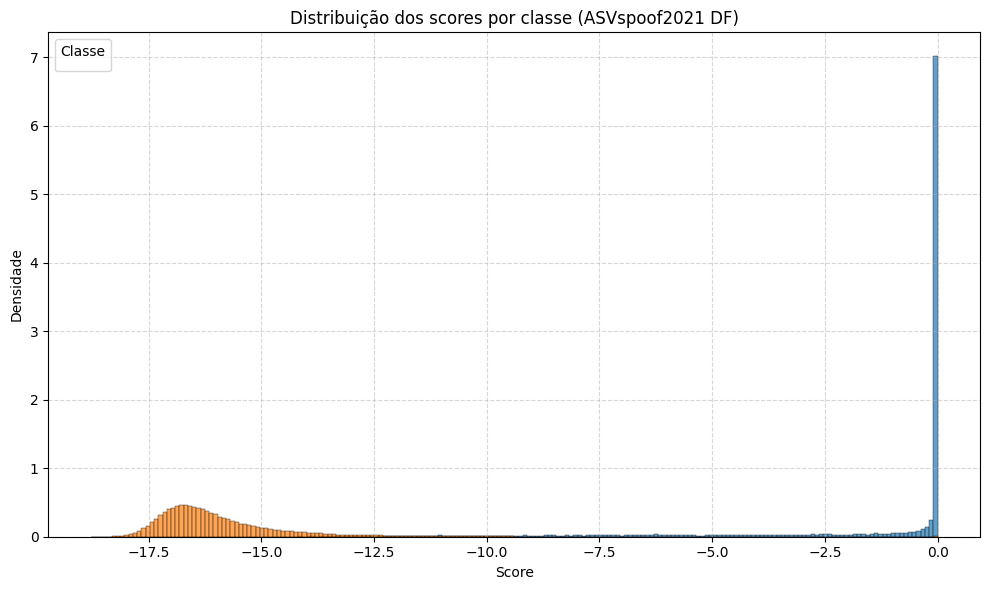

In [5]:
# Cell X: Plot da distribuição dos scores por classe

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=df_scores, 
    x="score", 
    hue="df_class", 
    bins=200, 
    stat="density", 
    common_norm=False, 
    palette={"bonafide": "tab:blue", "spoof": "tab:orange"},
    alpha=0.7
)
plt.title("Distribuição dos scores por classe (ASVspoof2021 DF)")
plt.xlabel("Score")
plt.ylabel("Densidade")
plt.legend(title="Classe")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()